[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6091662638518728451
xla_global_id: -1
]


Copying files: 19112 files [01:27, 218.49 files/s]


here: 8677
here: 15289
here: 2170
here: 3823
Found 15289 images belonging to 2 classes.
Found 3823 images belonging to 2 classes.


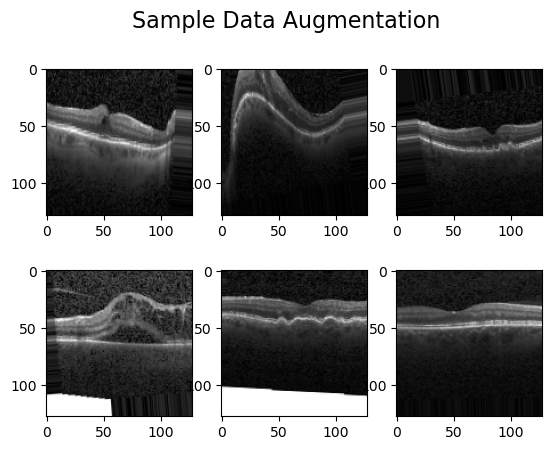

y Labels:  [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
sample img, max value:  0.91637623
sample img, min value:  2.0646115e-05
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       

C:\Users\Mike\anaconda3\envs\tensflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Mike\AppData\Local\Temp\ipykernel_1516\4004574703.py:179: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/15
509/509 [==============================] - 998s 2s/step - loss: 0.4144 - accuracy: 0.8548 - val_loss: 0.1452 - val_accuracy: 0.9457
Epoch 2/15
509/509 [==============================] - 994s 2s/step - loss: 0.1963 - accuracy: 0.9412 - val_loss: 0.1512 - val_accuracy: 0.9420
Epoch 3/15
509/509 [==============================] - 991s 2s/step - loss: 0.1616 - accuracy: 0.9522 - val_loss: 0.1481 - val_accuracy: 0.9507
Epoch 4/15
509/509 [==============================] - 987s 2s/step - loss: 0.1484 - accuracy: 0.9559 - val_loss: 0.1006 - val_accuracy: 0.9617
Epoch 5/15
509/509 [==============================] - 985s 2s/step - loss: 0.1231 - accuracy: 0.9657 - val_loss: 0.1049 - val_accuracy: 0.9627
Epoch 6/15
509/509 [==============================] - 989s 2s/step - loss: 0.1205 - accuracy: 0.9649 - val_loss: 0.0961 - val_accuracy: 0.9635
Epoch 7/15
509/509 [==============================] - 985s 2s/step - loss: 0.1068 - accuracy: 0.9687 - val_loss: 0.0908 - val_accuracy: 0.9661

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import os
import splitfolders

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


train_dir_original = r'\Users\Mike\Desktop\biomed1\Data\train'
test_dir = r'\Users\Mike\Desktop\biomed1\Data\test'
splitFolder = r'\Users\Mike\Desktop\biomed1\Data\splitFolder'

splitfolders.ratio(train_dir_original, output=splitFolder, seed=1337, ratio=(.8, .2))

train_dir_split = r'\Users\Mike\Desktop\biomed1\Data\splitFolder\train'
valid_dir_split = r'\Users\Mike\Desktop\biomed1\Data\splitFolder\val'


#COUNTING THE IMAGES IN TRAIN - DME AND DRUSEN
train_dir_split_count = 0
dir1 = train_dir_split + '/DME'
for path in os.listdir(dir1):
    if os.path.isfile(os.path.join(dir1, path)):
        train_dir_split_count += 1
print('here:',train_dir_split_count)

dir1 = train_dir_split + '/DRUSEN'
for path in os.listdir(dir1):
    if os.path.isfile(os.path.join(dir1, path)):
        train_dir_split_count += 1
print('here:',train_dir_split_count)

#COUNTING THE IMAGES IN VALID - DME AND DRUSEN
valid_dir_split_count = 0
dir2 = valid_dir_split + '/DME'
for path in os.listdir(dir2):
    if os.path.isfile(os.path.join(dir2, path)):
        valid_dir_split_count += 1
print('here:',valid_dir_split_count)

dir2 = valid_dir_split + '/DRUSEN'
for path in os.listdir(dir2):
    if os.path.isfile(os.path.join(dir2, path)):
        valid_dir_split_count += 1
print('here:',valid_dir_split_count)


# Training parameters
epochs = 15
freq = 20
batch_size = 30


class_weights = {0: 2.,
                1: 1.,
                2: 1.}



#ImageDataGenerator
#ImageDataGenerator
datagen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')


#Reading from the directory
train_generator = datagen.flow_from_directory(
    directory=train_dir_split,
    target_size=(128, 128),
    color_mode="rgb",    
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_generator = datagen.flow_from_directory(
    directory=valid_dir_split,
    target_size=(128, 128),
    color_mode="rgb",    
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


# Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))


# Build Model
image_input = Input(shape = (128, 128, 3))
base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                 include_top = False,
                                 weights = 'imagenet')

base_output = base_model.layers[-1].output

flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(2, activation = 'softmax')(dropfc2)

for layer in base_model.layers[:-9]:
    layer.trainable = False

model = Model(image_input, output)


# Compile the model
opt = Adam(lr = 0.00001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])


# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(1)
os.mkdir(name_dir)



# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(1) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, period = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(1)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)

# Display model
model.summary()



history = model.fit_generator(train_generator,
                              epochs = epochs,
                              steps_per_epoch = train_dir_split_count // batch_size,
                              validation_data = valid_generator,
                              validation_steps = valid_dir_split_count // batch_size,
                              callbacks = [check, tensor_board],
                              class_weight = class_weights)

early_stop_name = name_dir + '/fold_num_' + str(1) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [6]:
# Data organization

class_names = ['A. DME', 'B. DRUSEN']

In [11]:

test_dir_split_count = 895

test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')

#Reading from the directory
test_generator = datagen.flow_from_directory(
    directory= r"C:\Users\Mike\Desktop\New folder (3)",
    target_size=(128, 128),
    color_mode="rgb",    
    batch_size=20,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


X, y_true = [], []

Found 895 images belonging to 1 classes.


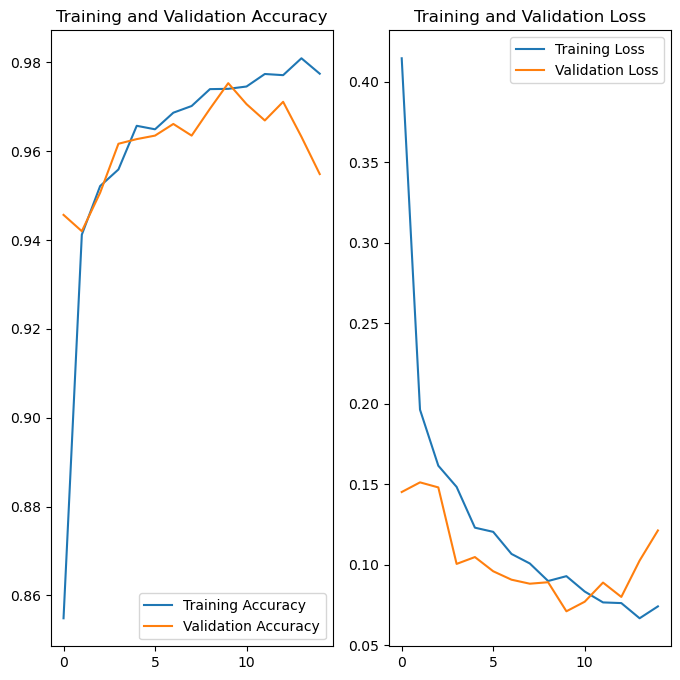

In [12]:
#Making Plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
i = 0
while i < 30:
    temp_X, temp_y_true = test_generator.next()
    if i < 1:
        X = temp_X
        y_true = temp_y_true
    else:
        X = np.concatenate((X, temp_X), axis=0)
        y_true = np.concatenate((y_true, temp_y_true), axis = 0)
    i += 1
    
print(np.shape(X))
print(np.shape(y_true))


y_pred = model.predict(X)

(600, 128, 128, 3)
(600, 1)
19/19 [==============================] - 13s 648ms/step


Categorical Classification
---------------------
Normalized confusion matrix
[[0.78166667 0.21833333]
 [       nan        nan]]


C:\Users\Mike\AppData\Local\Temp\ipykernel_1516\2537290419.py:23: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<AxesSubplot: title={'center': 'Confusion matrix, with normalization, fold: 1'}, xlabel='Predicted label', ylabel='True label'>

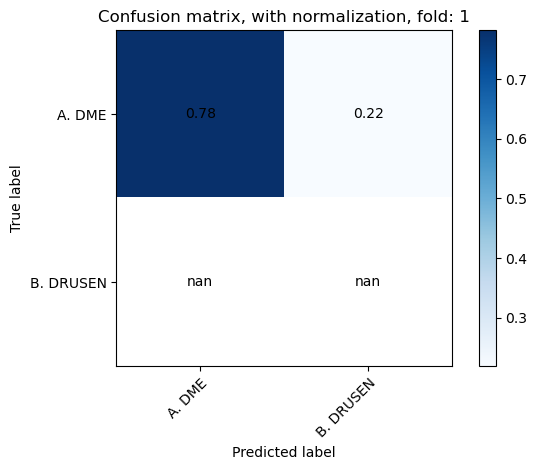

In [14]:
#Making matrix
title_mat = 'Confusion matrix, with normalization, fold: ' + str(1)
plot_name = name_dir + '/confusion_matrix_fold' + str(1) + '.png'

print('Categorical Classification')
print('---------------------')
plot_confusion_matrix(y_true.argmax(axis=1),
                        y_pred.argmax(axis=1),
                        classes = class_names,
                        normalize = True,
                        title = title_mat)